<a href="https://colab.research.google.com/github/kina19131/Machine-Learning-Algorithm/blob/master/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [ ]:
#Install Objax
!pip --quiet install  objax
import objax

In [ ]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170508288/170498071 [==============================] - 6s 0us/step


## PART 1.1 
How many iterations will it take to go through the entire training set given the number of training examples yielded by the data split? 
> $\frac{60,000 examples\;*\;0.8}{32\;per\;batch} = 1500$ iterations per epoch

How many iterations are there in 30 epochs? 
Recall that one epoch is the number of iterations needed to train over the entire dataset.
> $1500\;iterations/epochs\;*\;30\;epochs\;=\;45,000iterations$





Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



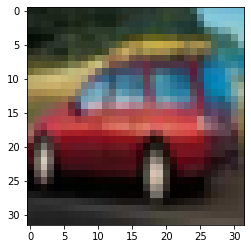

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.

##1.2

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [ ]:
#Solution to the above problem
my_conv_output = np.zeros((1,2, 32, 32))
def my_conv_net(my_image, initial_filter_weights):
  for n in range(1): # 1 because we are doing for 1 image
    for c in range (2): # output channel = 2
      for h in range (32): # image height = 32
        for w in range (32): # image weight = 32
          for t in range (3): # input depth = 3 := R, G, B
            for i in range (1): # kernel height
              for j in range (1): # kernel width
                my_conv_output[n, c, h, w] += my_image[n,t,i+h,j+w]*initial_filter_weights[i,j,t,c]
  return my_conv_output
'''
Even though for the completeness, included 7 for loops for 7 parameters, 
this can be condensed to 4 parameters. This is due to n = i = j = 1 from given 
information. Since they are 1's, there is no need to be for-looped.
'''

my_conv_output = my_conv_net(my_image, filter_weights)

print(my_conv_output)

[[[[-0.10271907 -0.10010862 -0.09076816 ... -0.7420423  -0.73912489
    -0.73746228]
   [-0.12882358 -0.11180527 -0.11687266 ... -0.73105443 -0.74346107
    -0.74085063]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.69911373 -0.71740329
    -0.71560836]
   ...
   [-0.11485984 -0.10963892 -0.10963892 ... -0.11178758 -0.11439803
    -0.12222938]
   [-0.09658667 -0.09136577 -0.09136577 ... -0.12745032 -0.12483985
    -0.12483985]
   [-0.08614486 -0.08353443 -0.08614486 ... -0.16399662 -0.16138616
    -0.15355483]]

  [[ 0.10279882  0.09823449  0.08189839 ...  0.75253248  0.7320599
     0.72146261]
   [ 0.14844204  0.12636711  0.1275416  ...  0.7793448   0.76264036
     0.75807607]
   [ 0.15300636  0.12562042  0.15036322 ...  0.7925384   0.7784524
     0.77533197]
   ...
   [ 0.20083013  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.15975127  0.15975127 ...  0.29957128  0.29500696
     0.29500696]
   [ 0.15062262  0.14605829  0.15062262 ...  0.3634

##1.3


In [ ]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

array([[-0.1400071 ,  0.35388903]])

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [ ]:
#Objax's linear layer
Linear_Layer = objax.nn.Linear(2, 1) # N = dimension of output


output = np.dot(my_conv_output.mean((2,3)), Linear_Layer.w.value) # My linear layer
Obj_linear = Linear_Layer(my_conv_output.mean((2,3))) # Objax's linear Layer

print("Objax Linear: ", Obj_linear)
print("My Linear: ", output)
print("Objax Linear and My Linear are the same: ", Obj_linear == output)


Objax Linear:  [[-0.09563078]]
My Linear:  [[-0.09563078]]
Objax Linear and My Linear are the same:  [[ True]]


## 1.4
**Explain in a short paragraph what is the difference between the training and validation set.**


Training set is used to train the model. You can obtain weights and biases for the model by running it through the training set. 

The purpose of the validation set is slightly different. It works as an unbiased evaluation of the model fit and it serves the purpose of tunning the hyperparameters. 

**You have now completed Part 1 of the assignment. Good job!**


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

##2.1

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
         params.value = params.value - lr*grad          
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

##2.2

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH): 
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
      

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

##2.3 

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.03
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.02
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.90 Validation Accuracy 10.32
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.52 Validation Accuracy 10.58
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.49 Validation Accuracy 11.25
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 10.77
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 11.62
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.50 Validation Accuracy 12.08
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.84 Validation Accuracy 12.25
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.33 Validatio

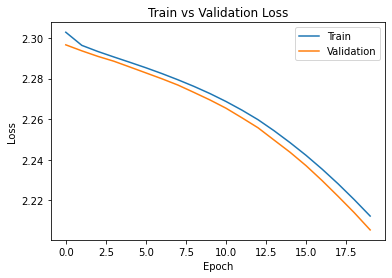

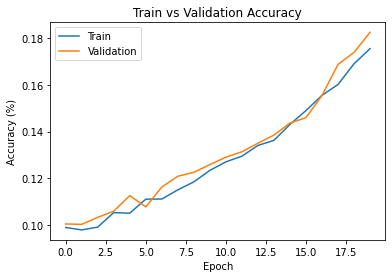

In [ ]:
train()

##2.4
**Define the meaning of a “hyperparameter”** <br>
 
They are tunable variables that determine the learning process unlike other parameters which are discovered in the progress of training the train set. 

<br>

**Explain in a short paragraph why it is important not to evaluate the accuracy on the test set until all hyperparameters have been tuned.** <br> 
Evaluating the accruacy on the test set is in a sense a cheating. Test set is used to "test" the accuracy of the model. However, changing the hyperparameters after running it on test set, you are fitting it to the test set. This then no longer is a valid "test" to check the trained model afterwards. The test accuracy has high potential of being higher than how it's supposed to be. 


##2.5
**Select 4 hyperparameters associated with your network, one of the hyperparameter must involve your CNN architecture, and come up with two different sets of hyperparameters.** <br>

Example: \\
H = {Batch, Learning Rate, # of outputs of conv layer 1, # of conv layers} 

Mine: \\
H = {Epoch, Batch, Learning Rate, # of outputs of conv layer 1} <br>

H_default = {epochs = 20, batch = 32, learning_rate = 9e-4, # of outputs on conv_layer1 = 16} <br>
H1 = {epochs = 15, batch = 64, learning_rate = 0.005, # of outputs on conv_layer1 = 8} <br>
H2 = {epochs = 25, batch = 128, learning_rate = 0.01, # of outputs on conv_layer1 = 32}


##2.6

### First set of Hyperparameters
H1 = {epochs = 15, batch = 64, learning_rate = 0.005, # of outputs on conv_layer1 = 8}

In [ ]:
class ConvNet2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 8, 2), objax.functional.relu]) # Number of output layers: 16 -> 8
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(8, 32, 2), objax.functional.relu]) # Number of output layers: 16 -> 8
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet2()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
         params.value = params.value - lr*grad          
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH): 
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
      

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.41 Validation Accuracy 12.98
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 14.39 Validation Accuracy 14.57
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 14.80 Validation Accuracy 15.72
Epoch 0004  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 16.05 Validation Accuracy 15.57
Epoch 0005  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 15.97 Validation Accuracy 15.85
Epoch 0006  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 16.68 Validation Accuracy 17.07
Epoch 0007  Training Loss 2.24 Validation Loss 2.22 Training Accuracy 17.42 Validation Accuracy 16.93
Epoch 0008  Training Loss 2.21 Validation Loss 2.19 Training Accuracy 18.17 Validation Accuracy 17.12
Epoch 0009  Training Loss 2.18 Validation Loss 2.16 Training Accuracy 18.41 Validation Accuracy 18.17
Epoch 0010  Training Loss 2.15 Validation Loss 2.14 Training Accuracy 19.48 Valida

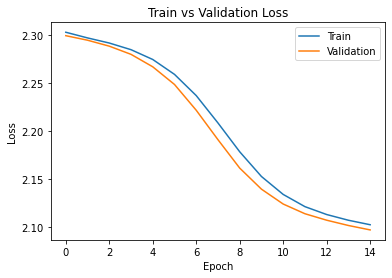

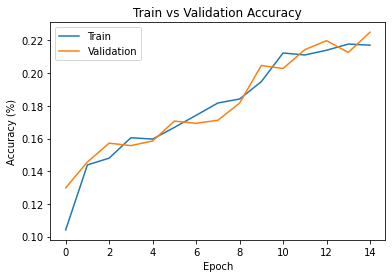

In [ ]:
train(EPOCHS = 15, BATCH = 64, LEARNING_RATE = 0.005)

### Second Hyper parameter
H2 = {epochs = 25, batch = 128, learning_rate = 0.01, # of outputs on conv_layer1 = 32}

In [ ]:
class ConvNet3(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu]) # Number of output layers: 16 -> 32
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu]) # Number of output layers: 16 -> 32
    self.linear = objax.nn.Linear(32, number_of_classes) 

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet3()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
         params.value = params.value - lr*grad          
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

Epoch 0001  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 12.08 Validation Accuracy 13.35
Epoch 0002  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 15.31 Validation Accuracy 17.20
Epoch 0003  Training Loss 2.25 Validation Loss 2.23 Training Accuracy 17.96 Validation Accuracy 17.22
Epoch 0004  Training Loss 2.22 Validation Loss 2.20 Training Accuracy 18.70 Validation Accuracy 17.47
Epoch 0005  Training Loss 2.18 Validation Loss 2.16 Training Accuracy 19.60 Validation Accuracy 21.17
Epoch 0006  Training Loss 2.15 Validation Loss 2.13 Training Accuracy 20.72 Validation Accuracy 20.35
Epoch 0007  Training Loss 2.12 Validation Loss 2.11 Training Accuracy 22.03 Validation Accuracy 21.80
Epoch 0008  Training Loss 2.11 Validation Loss 2.10 Training Accuracy 23.15 Validation Accuracy 23.80
Epoch 0009  Training Loss 2.10 Validation Loss 2.09 Training Accuracy 23.84 Validation Accuracy 22.52
Epoch 0010  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 23.75 Valida

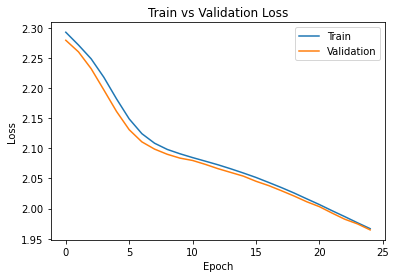

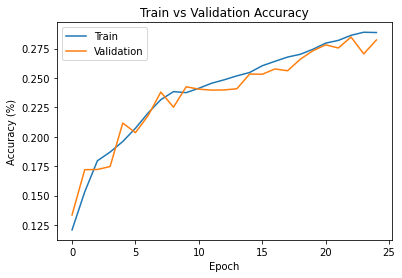

In [ ]:
train(EPOCHS = 25, BATCH = 128, LEARNING_RATE = 0.01)

**Report the best validation accuracy as well as the corresponding epoch for which this occurs for the Base Model and your two additional models.**<br>


* Base Model: 18.27% at epoch 20
* M1: 22.50% at epoch 15
* M2: 28.23% at epoch 25



<br><br>
**Which model performs the best in terms of validation accuracy?** <br>
From above, <br>
=> Base Model (18.27%) < M1 (22.50%) < M2 (28.23%) for given hyperparameters<br>

Based on this, it can be concluded that M2 model with the Hyperparamters of H2 = {epochs = 25, batch = 128, learning_rate = 0.01, # of outputs on conv_layer1 = 32} has the highest validation accuracy with 28.23% and therefore is the model that performs the best.



Therefore, M2 is the model that performs the best in terms of validation accuracy. 



##2.7

**Based on your answer, which model should you pick as your final model and why? Then evaluate your model on the test set and report final test accuracy.**

Since M2 had the highest validation accuracy, it implies it has the least loss and it is the best-trained model. Therefore, I will pick M2 and run test set and report the final test accuracy. <br>

As shown below, M2 model gives the test set accuracy of 27.92%. Reflecting upon its validation accuracy of 28.23%, this is a reasonable value. I can assure no overfitting or underfitting is happening. 

In [ ]:
def test(EPOCHS = 20, BATCH = 1, LEARNING_RATE = 9e-4):
  test_loss = 0 # (averaged) loss per batch
  test_acc = 0      # training accuracy per batch

  # shuffle the data prior to training to remove correlation 
  test_indices = np.arange(len(X_test)) 
  np.random.shuffle(test_indices)

  for it in range(0, X_test.shape[0], BATCH): 
    batch = test_indices[it:it+BATCH] 
    test_prediction = predict(X_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
      
  print('Test Accuracy %.2f' % (100*test_acc/X_test.shape[0]))

test()

Test Accuracy 27.92


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


In [ ]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

#### STEP1. Presetting (Loading Data, split)

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.transpose(0, 3, 1, 2) /255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

## HYPERPARAMETERS TO BE CONSIDERED: 

**Which hyperparameters you tuned?** <br>
H = {Epochs, Batch, Learning_Rate, Activation_Function}


---



### BASE MODEL:
H_default = {Epochs = 20, Batch = 32, Learning_rate = 9e-4, Activation_Function = ReLU}

### Step 2. Build architecture

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10): # number_of_channels = 1 since mnist is black/white, # of classes = modified to fit mnist
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu]) 
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
         params.value = params.value - lr*grad          
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

### Step 2. Train

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH): 
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
      

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.63 Validation Accuracy 9.67
Epoch 0002  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.01 Validation Accuracy 10.97
Epoch 0003  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 12.04 Validation Accuracy 13.56
Epoch 0004  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 14.33 Validation Accuracy 15.40
Epoch 0005  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 16.45 Validation Accuracy 17.21
Epoch 0006  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 17.83 Validation Accuracy 18.57
Epoch 0007  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 19.21 Validation Accuracy 19.64
Epoch 0008  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 20.19 Validation Accuracy 20.26
Epoch 0009  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 20.74 Validation Accuracy 20.16
Epoch 0010  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 20.93 Validati

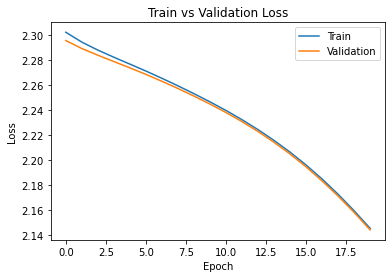

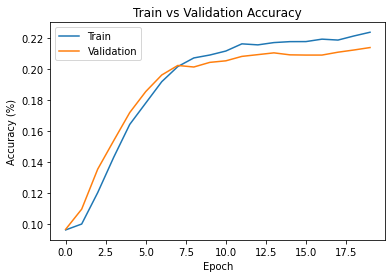

In [ ]:
train()

### TUNED HYPERPARAMETER MODEL: 

H_modified = { Epochs = 30, Batch = 56, Learning_Rate = 0.01, tanh}

In [ ]:
class ConvNet_modified(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.tanh])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.tanh]) 
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet_modified()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
         params.value = params.value - lr*grad          
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

Epoch 0001  Training Loss 2.26 Validation Loss 2.23 Training Accuracy 18.61 Validation Accuracy 18.93
Epoch 0002  Training Loss 2.20 Validation Loss 2.17 Training Accuracy 20.61 Validation Accuracy 20.17
Epoch 0003  Training Loss 2.14 Validation Loss 2.12 Training Accuracy 22.15 Validation Accuracy 21.96
Epoch 0004  Training Loss 2.09 Validation Loss 2.07 Training Accuracy 23.80 Validation Accuracy 22.44
Epoch 0005  Training Loss 2.05 Validation Loss 2.04 Training Accuracy 24.68 Validation Accuracy 23.27
Epoch 0006  Training Loss 2.02 Validation Loss 2.02 Training Accuracy 25.43 Validation Accuracy 23.87
Epoch 0007  Training Loss 1.99 Validation Loss 2.00 Training Accuracy 26.06 Validation Accuracy 24.76
Epoch 0008  Training Loss 1.98 Validation Loss 1.98 Training Accuracy 26.81 Validation Accuracy 25.40
Epoch 0009  Training Loss 1.96 Validation Loss 1.97 Training Accuracy 27.16 Validation Accuracy 26.46
Epoch 0010  Training Loss 1.95 Validation Loss 1.95 Training Accuracy 27.48 Valida

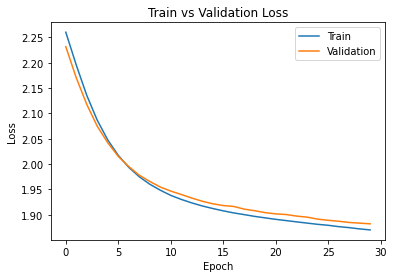

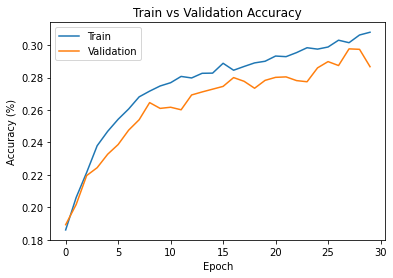

In [ ]:
train(EPOCHS = 30, BATCH = 56, LEARNING_RATE = 0.01)

**Select your final model and report test accuracy.**

Since the best validation of the modified hyperparameter model (29.77%) is higher than the best validation of the base model (21.41%), I will use the modified hyperparameter model to run the test set. 

As shown below, the the test accuracy of my best model is 29.74%. 

In [ ]:
def test(BATCH = 1):
  test_loss = 0 # (averaged) loss per batch
  test_acc = 0      # training accuracy per batch

  # shuffle the data prior to training to remove correlation 
  test_indices = np.arange(len(X_test)) 
  np.random.shuffle(test_indices)

  for it in range(0, X_test.shape[0], BATCH): 
    batch = test_indices[it:it+BATCH] 
    test_prediction = predict(X_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
      
  print('Test Accuracy %.2f' % (100*test_acc/X_test.shape[0]))

test()

Test Accuracy 29.74


##**Problem 4. Open-Ended Exploration**

**Additional hyperparameter tuning Come up with one or several hyperparameters that you have not tried in the previous parts (e.g., explore arguments of the method objax.nn.Cov2d), tune them on the validation set until you see (at-least) 5%-10% increase in the validation accuracy as compared to a base model.**

### HYPERPARAMETERS:
Tunning hyperparameters: <br>
H = {Epochs, Batch, Learning_rate, Size of the convolution kernel (k), # of outputs of conv layer 1, # of outputs of conv layer 2}<br>
> Newly introduced hyperparamters: 'Size of the convolution kernel', '# of outputs of conv layer 2'



### Base Model 
H_default = { Epochs = 20, Batch = 32, Learning_rate = 9e-4, k = 2, # of outputs of conv layer 1 = 16, # of outputs of conv layer 2 = 32}

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu]) 
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu]) 
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
         params.value = params.value - lr*grad          
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH): 
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
      

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 9.89 Validation Accuracy 11.69
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.81 Validation Accuracy 14.14
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 14.99 Validation Accuracy 17.31
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 18.77 Validation Accuracy 20.43
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 20.75 Validation Accuracy 21.53
Epoch 0006  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 21.74 Validation Accuracy 21.64
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 21.26 Validation Accuracy 20.13
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 21.51 Validation Accuracy 20.99
Epoch 0009  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 21.74 Validation Accuracy 21.14
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 21.46 Validat

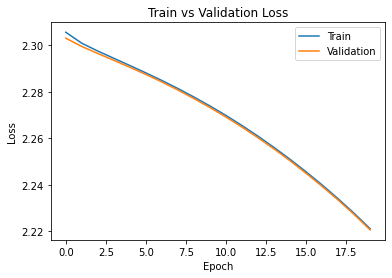

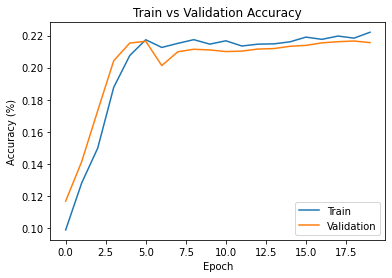

In [ ]:
train()

In [ ]:
def test(BATCH = 1):
  test_loss = 0 # (averaged) loss per batch
  test_acc = 0      # training accuracy per batch

  # shuffle the data prior to training to remove correlation 
  test_indices = np.arange(len(X_test)) 
  np.random.shuffle(test_indices)

  for it in range(0, X_test.shape[0], BATCH): 
    batch = test_indices[it:it+BATCH] 
    test_prediction = predict(X_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
      
  print('Test Accuracy %.2f' % (100*test_acc/X_test.shape[0]))

test()

Test Accuracy 21.94


## Tuned Hyperparameter Model
H_modified= { Epochs = 30, Batch = 56, Learning_rate = 0.005, k = 4, # of outputs of conv layer 1 = 32, # of outputs of conv layer 2 = 64}

In [ ]:
class ConvNet_Modified(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 4), objax.functional.tanh]) # k = 2 -> 4
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 4), objax.functional.tanh]) # k = 2 -> 4
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet_Modified()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
         params.value = params.value - lr*grad          
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH): 
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
      

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.25 Validation Loss 2.20 Training Accuracy 17.69 Validation Accuracy 21.33
Epoch 0002  Training Loss 2.14 Validation Loss 2.09 Training Accuracy 22.80 Validation Accuracy 22.86
Epoch 0003  Training Loss 2.05 Validation Loss 2.02 Training Accuracy 25.09 Validation Accuracy 25.37
Epoch 0004  Training Loss 1.99 Validation Loss 1.98 Training Accuracy 27.51 Validation Accuracy 26.66
Epoch 0005  Training Loss 1.95 Validation Loss 1.95 Training Accuracy 28.91 Validation Accuracy 28.56
Epoch 0006  Training Loss 1.92 Validation Loss 1.92 Training Accuracy 30.23 Validation Accuracy 29.84
Epoch 0007  Training Loss 1.90 Validation Loss 1.90 Training Accuracy 31.40 Validation Accuracy 30.59
Epoch 0008  Training Loss 1.88 Validation Loss 1.89 Training Accuracy 32.34 Validation Accuracy 31.69
Epoch 0009  Training Loss 1.87 Validation Loss 1.87 Training Accuracy 33.75 Validation Accuracy 32.94
Epoch 0010  Training Loss 1.85 Validation Loss 1.86 Training Accuracy 35.05 Valida

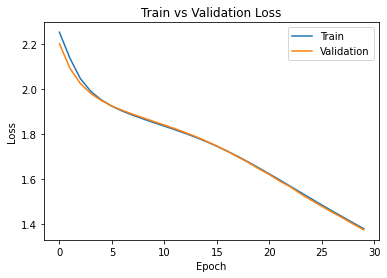

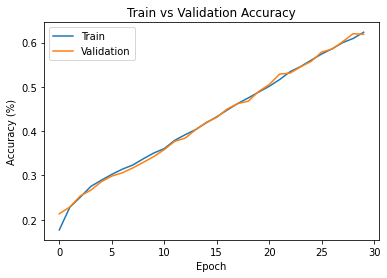

In [ ]:
train(EPOCHS = 30, BATCH = 56, LEARNING_RATE = 0.005)

In [ ]:
def test(BATCH = 1):
  test_loss = 0 # loss per batch
  test_acc = 0      # training accuracy per batch

  # shuffle the data prior to training to remove correlation 
  test_indices = np.arange(len(X_test)) 
  np.random.shuffle(test_indices)

  for it in range(0, X_test.shape[0], BATCH): 
    batch = test_indices[it:it+BATCH] 
    test_prediction = predict(X_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
      
  print('Test Accuracy %.2f' % (100*test_acc/X_test.shape[0]))

test()

Test Accuracy 62.41


**Discuss whether it performs well on the test set as compared to your base model.** <br>

Test Accuracy for Base Model: 22.97% <br>
> H_default = { Epochs = 20, Batch = 32, Learning_rate = 9e-4, k = 2, Activation_Function = relu} 

Test Accuracy for Modified Model: 62.41% <br>
> H_modified= { Epochs = 30, Batch = 56, Learning_rate = 0.005, k = 4, Activation_Function = tanh} <br>




The test accuracy for the modified model is almost triple the test accuracy of the base model. This clearly tells that the tuned hyperparameter has improved the model. 


